In [1]:
# Import packages for plotting and numerical processing.
import matplotlib.pyplot as plt
import numpy as np

# Import tensorflow and keras.
import tensorflow as tf
from tensorflow.keras.datasets import mnist

First, let's load and investigate the MNIST data.

In [2]:
# Load MNIST data.
mnist_data = mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist_data

In [3]:
# Look at format of data.
print("Training X:", x_train.shape)
print("Training Y:", y_train.shape, y_train[:10])
print("Test X:    ", x_test.shape)
print("Test Y:    ", y_test.shape, y_test[:10])

Training X: (60000, 28, 28)
Training Y: (60000,) [5 0 4 1 9 2 1 3 1 4]
Test X:     (10000, 28, 28)
Test Y:     (10000,) [7 2 1 0 4 1 4 9 5 9]


We can see that we have 60 000 training samples (first dimension of training data) and 10 000 test samples (first dimension of training data). We can also see that samples are 28x28 2D arrays, and labels are integers from 0 to 9.

In [4]:
# Look at data.
def plot_random_training_samples(num, size=5):
  # Create a figure with num subplots (+1 for the colorbar).
  ncols = num + 1
  fig, axes = plt.subplots(ncols=ncols, figsize=(size * ncols, size))

  # Pick random training samples.
  samples = np.random.choice(len(x_train), num)
  # Show each training sample as image using `ax.imshow()` and "gray" colormap.
  for sample, ax in zip(samples, axes.flat):
    ax.set_title("Training Sample #{}".format(sample))
    img = ax.imshow(x_train[sample], cmap="gray")

  # Add a colorbar in last column.
  plt.colorbar(img, cax=axes[-1])

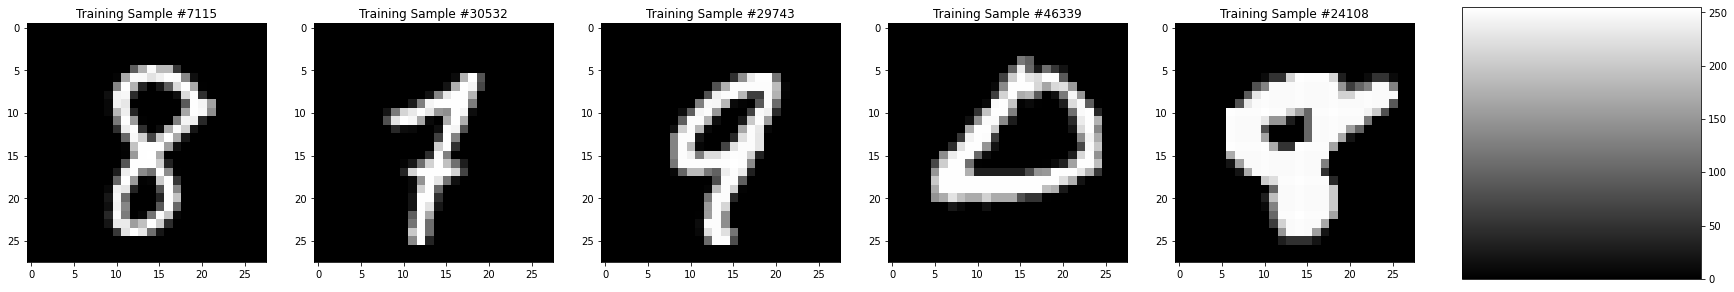

In [5]:
plot_random_training_samples(num=5)

We can see that we have quadratic images with black background (0) and white (255) writing.

Next, we will repare our learning model.

In [6]:
# Import keras from tensorflow, some layers and the Model class.
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

In [7]:
# Prepare the model.
def create_model() -> Model:

  # An input layer with input shape is 28x28.
  input_shape = (28, 28)
  inputs = Input(shape=input_shape)
  print("Inputs: ", inputs.shape)
  
  # Flatten the image to a one-dimensional array (discarding the image structure).
  inputs_flat = Flatten()(inputs)

  # Create some fully-connected (Dense) hidden layers and apply them to the input.
  hidden_1 = Dense(128, activation="relu")(inputs_flat)
  hidden_2 = Dense(128, activation="relu")(hidden_1)
    
  # Create the output layer, which does 10-class classification.
  # Therefore, the output size is 10 and we use softmax as activation.
  outputs = Dense(10, activation="softmax")(hidden_2)
  print("Outputs:", outputs.shape)

  # Build the model by specifying input and output layers.
  model = Model(inputs=inputs, outputs=outputs)
  # Compile the model by specifying the optimizer, loss and metrics we want
  # to obtain during training.
  model.compile(optimizer="sgd",  # try: "sgd", "adam"
                loss="categorical_crossentropy", 
                metrics=["accuracy"])
  
  return model

In [8]:
# Now, create the model.
model = create_model()

# We can look at the model structure, layer size and number of 
# parameters in the model's summary.
print(model.summary())

Inputs:  (None, 28, 28)
Outputs: (None, 10)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
None


Classes are usually encoded as "one-hot vectors". A one-hot vector encodes and integer (class ID) as a vector with one entry being 1 (at the index of the class) and the rest being zero.

We see a short demo of how we can convert integers to one-hot vectors.

In [9]:
# One hot encoding: demo
from tensorflow.keras.utils import to_categorical

# Example:
def categorical_demo():
  # Integers, e.g. class IDs.
  data = np.array([1, 2, 4, 6])
  # The number of classes, i.e. size of one-hot vectors.
  num_classes = 10
  # We can use Keras' function `to_categorical()` to convert to one-hot encoding.
  categ = to_categorical(data, num_classes)
  print("Input:", data.shape, "\n", data)
  print("One hot:", categ.shape, "\n", categ)

categorical_demo()

Input: (4,) 
 [1 2 4 6]
One hot: (4, 10) 
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [10]:
# Prepare training data

from tensorflow.keras.utils import to_categorical

# We wrap the encoding of input and output data in two functions.

def encode_x(x):
  # For training, we simple normalize the pixel values from {0, ..., 255} to [0., 1.].
  # Try disabling this normalization and see how training behaves.
  return x / 255.0

def encode_y(y):
  # We encode class labels as one-hot vectors.
  return to_categorical(y, num_classes=10)

# Encode data and compare shapes.
x_train_enc = encode_x(x_train)
print("Shape of X before:", x_train.shape)
print("Shape of X after: ", x_train_enc.shape)

y_train_enc = encode_y(y_train)
print("Shape of Y before:", y_train.shape)
print("Shape of Y after: ", y_train_enc.shape)

# Input data has kept its format, but has changed its value range (look at and compare some values).
# Output shape has changed from integers to vectors.

Shape of X before: (60000, 28, 28)
Shape of X after:  (60000, 28, 28)
Shape of Y before: (60000,)
Shape of Y after:  (60000, 10)


In [11]:
# With our model constructed and data prepared, we can train the model by calling `fit()`.

# Train in single run.
model = create_model()

# Iterate 10 times through the whole training data.
num_epochs = 10

# Pass input and output data and specify parameters (e.g. number of epochs).
# During training, Keras will provide a progress bar and live stats such as loss and accuracy.
history = model.fit(x=x_train_enc, y=y_train_enc, epochs=num_epochs)

Inputs:  (None, 28, 28)
Outputs: (None, 10)
Epoch 1/10
1875/1875 [==============================] - 2s 828us/step - loss: 0.6513 - accuracy: 0.8310
Epoch 2/10
1875/1875 [==============================] - 2s 830us/step - loss: 0.2956 - accuracy: 0.9162
Epoch 3/10
1875/1875 [==============================] - 2s 849us/step - loss: 0.2458 - accuracy: 0.9301
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2121 - accuracy: 0.9395
Epoch 5/10
1875/1875 [==============================] - 2s 870us/step - loss: 0.1857 - accuracy: 0.9474
Epoch 6/10
1875/1875 [==============================] - 2s 919us/step - loss: 0.1654 - accuracy: 0.9530
Epoch 7/10
1875/1875 [==============================] - 2s 900us/step - loss: 0.1489 - accuracy: 0.9579
Epoch 8/10
1875/1875 [==============================] - 2s 879us/step - loss: 0.1355 - accuracy: 0.9613
Epoch 9/10
1875/1875 [==============================] - 2s 951us/step - loss: 0.1238 - accuracy: 0.96560s - l
Epoch 10/10
1875

In [12]:
# From training, we obtain a "History" object, which contains the 
# loss and accuracy over the course of training.
# We ca plot it using matplotlib.

def plot_history(history_dict):
  fig, (ax_loss, ax_acc) = plt.subplots(nrows=2)
  ax_loss.plot(history_dict["loss"], label="Loss")
  ax_loss.set_ylabel("Loss")
  ax_loss.set_xlabel("Epochs")
  ax_loss.set_ylim(0, 1.1 * max(history_dict["loss"]))

  # Handle naming in different versions.
  if "acc" in history_dict:
        history_dict["accuracy"] = history_dict["acc"]
  
  ax_acc.plot(history_dict["accuracy"], label="Accuracy")
  ax_acc.set_ylim(0, 1.1)
  ax_acc.set_ylabel("Accuracy")
  ax_acc.set_xlabel("Epochs")

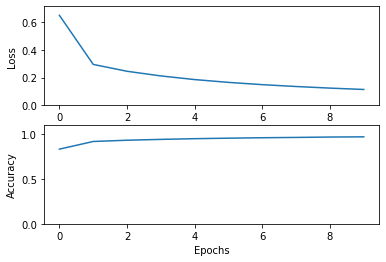

In [13]:
plot_history(history.history)

Looks good: Training loss is gradually dropping towards 0 and accuracy is approaching 1.

In [14]:
# We can evaluate the trained model on our test data.

# Encode the test data.
x_test_enc = encode_x(x_test)
y_test_enc = encode_y(y_test)

# Call `evaluate()` to apply our model without training it.
loss, acc = model.evaluate(x_test_enc, y_test_enc)

print("Test loss:    ", loss)
print("Test accuracy:", acc)

313/313 [==============================] - 0s 522us/step - loss: 0.1187 - accuracy: 0.9645
Test loss:     0.11870009452104568
Test accuracy: 0.9645000100135803


Sometimes it is useful to see what a model does over the course of training. 
There are different ways to do that, one is using "Keras callbacks".
Instead, here we will just run training multiple times (without resetting
the model) and evaluate on our test data during training.

Note that usually, you would use part of the training data as validation 
during training. (You can also pass the validation data directly to the `fit()` method.)
The test data is usually only used on the final model to test the performance.
All data you use to tune your model (including architecutre, hyperparamters, ...) is not test data anymore.

In [15]:
# Train in multiple runs.

def fit_and_evaluate(model: Model, num_epochs = 10, num_epochs_per_round = 1):

  histories_train = []
  history_test = {"loss": [], "acc": []}

  num_rounds = int(np.ceil(num_epochs / num_epochs_per_round))
  for round in range(num_rounds):

    # Evaluate on test data.
    print("[{}] Evaluate".format(round))
    loss, acc = model.evaluate(x_test_enc, y_test_enc)
    history_test["loss"].append(loss)
    history_test["acc"].append(acc)

    # Train model.
    print("[{}] Train".format(round))
    history_callback = model.fit(x_train_enc, y_train_enc, epochs=num_epochs_per_round)
    history = history_callback.history
    if "accuracy" in history:
        history["acc"] = history["accuracy"]
    histories_train.append(history)
  
  return histories_train, history_test

In [16]:
model = create_model()
histories_train, history_test = fit_and_evaluate(model, 10, 1)

Inputs:  (None, 28, 28)
Outputs: (None, 10)
[0] Evaluate
313/313 [==============================] - 0s 513us/step - loss: 2.3645 - accuracy: 0.1182
[0] Train
1875/1875 [==============================] - 2s 835us/step - loss: 0.6384 - accuracy: 0.8343
[1] Evaluate
313/313 [==============================] - 0s 667us/step - loss: 0.3196 - accuracy: 0.9081
[1] Train
1875/1875 [==============================] - 2s 847us/step - loss: 0.2988 - accuracy: 0.9142
[2] Evaluate
313/313 [==============================] - 0s 595us/step - loss: 0.2613 - accuracy: 0.9267
[2] Train
1875/1875 [==============================] - 2s 967us/step - loss: 0.2487 - accuracy: 0.92820s - loss: 0.2530 - accura
[3] Evaluate
313/313 [==============================] - 0s 663us/step - loss: 0.2205 - accuracy: 0.9356
[3] Train
1875/1875 [==============================] - 2s 875us/step - loss: 0.2159 - accuracy: 0.9377
[4] Evaluate
313/313 [==============================] - 0s 619us/step - loss: 0.1995 - accuracy: 0.942

In [17]:
# We need to merge training histories over the multiple runs.

def merge_histories(histories):
  result = {"loss": [], "acc": []}
  for history in histories:
    for key in result:
      result[key] += history[key]

  return result

history_train = merge_histories(histories_train)
print([(k, len(v)) for (k, v) in history_train.items()])

[('loss', 10), ('acc', 10)]


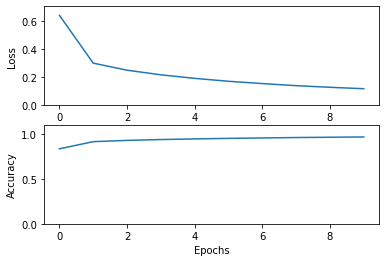

In [18]:
plot_history(history_train)

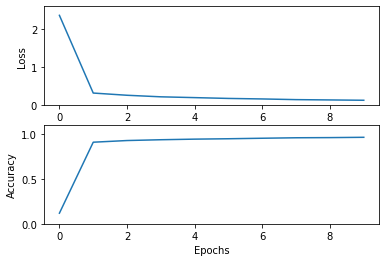

In [19]:
plot_history(history_test)

To apply the model to new input samples, we can use the method `predict()` to obtain the output values for one or more samples.

In [20]:
# Prediction
print("Single:")
pred = model.predict(x_test_enc[0:1])
pred_class = np.argmax(pred)
print("- Prediction:", pred_class, np.round(pred, 3))

print("Multiple:")
preds = model.predict(x_test_enc[0:3])
preds_class = np.argmax(preds, axis=-1)
for pred, pred_class in zip(preds, preds_class):
  print("- Prediction:", pred_class, np.round(pred, 3))

Single:
- Prediction: 7 [[0.    0.    0.    0.001 0.    0.    0.    0.999 0.    0.   ]]
Multiple:
- Prediction: 7 [0.    0.    0.    0.001 0.    0.    0.    0.999 0.    0.   ]
- Prediction: 2 [0.    0.    0.997 0.001 0.    0.    0.001 0.    0.    0.   ]
- Prediction: 1 [0.    0.98  0.005 0.001 0.    0.001 0.002 0.009 0.003 0.   ]


In [21]:
# We can use this to show what our model outputs for input samples.

def predict_random_test_samples(model: Model, x_data, num, size=5):
  ncols = num
  nrows = 2
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size * num, 2*size))
  
  # Pick random samples.
  sample_ids = np.random.choice(len(x_data), num)
  # Run the prediction, returning class probabilities.
  predictions = model.predict(x_data[sample_ids])
  # Get the most likely class.
  predictions_class = np.argmax(predictions, axis=-1)

  # Show the input images and prediction as bar chart.
  for i in range(ncols):
    ax_img, ax_pred = axes[:, i]
    ax_img.set_title("Prediction {}".format(predictions_class[i]))
    ax_img.imshow(x_data[sample_ids[i]].squeeze(), cmap="gray")
    ax_img.grid(False)
    ax_img.set_xticks([])
    ax_img.set_yticks([])

    ax_pred.bar(range(num), predictions[i])
    ax_pred.set_xticks(range(num))


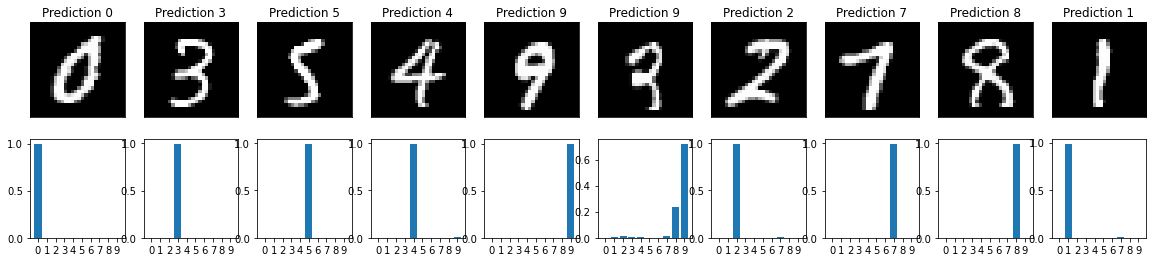

In [22]:
# Look at samples from training data.
predict_random_test_samples(model, x_train_enc, num=10, size=2)

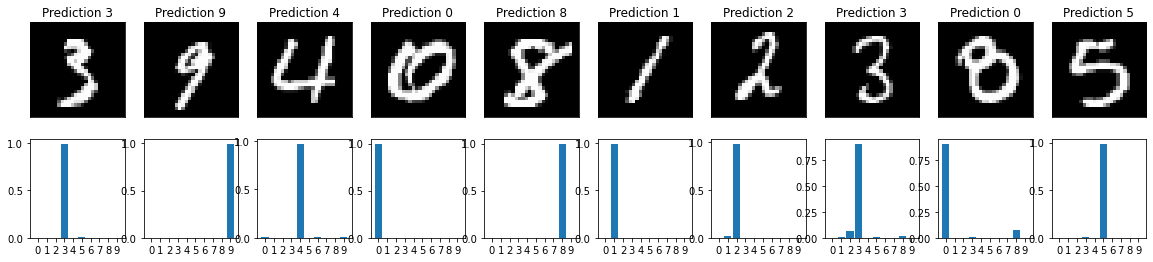

In [23]:
# Look at samples from "test" data.
predict_random_test_samples(model, x_test_enc, num=10, size=2)